<a href="https://colab.research.google.com/github/alimaazamat/AI4ALL/blob/main/collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity


from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_recipes_df = pd.read_csv('/content/drive/My Drive/AI4All/Recipes and Interactions Data/RAW_recipes.csv')
carbon_footprint_df = pd.read_csv('/content/drive/My Drive/AI4All/Environmental Impacts Dataset/Food_Production.csv')
ingr_df = pd.read_csv('/content/drive/My Drive/AI4All/Recipes and Interactions Data/ingr_map.csv')

raw_recipes_df.head()
#carbon_footprint_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [ ]:
recipes_df = pd.read_csv('/content/drive/My Drive/AI4All/Recipes and Interactions Data/PP_recipes.csv')
recipes_df.head()


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


In [ ]:
users_df = pd.read_csv('/content/drive/My Drive/AI4All/Recipes and Interactions Data/PP_users.csv')
users_df.head()

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


In [ ]:
ratings_list = []
for i in users_df.index:
    user = users_df.at[i, 'u']

    # Convert 'items' and 'ratings' to lists
    items = ast.literal_eval(users_df.at[i, 'items'])
    ratings = ast.literal_eval(users_df.at[i, 'ratings'])

    # Check if items and ratings lists are of the same length
    if len(items) != len(ratings):
        print(f"Length mismatch at index {i}: {len(items)} items, {len(ratings)} ratings.")
        continue

    for j, item in enumerate(items):
        ratings_list.append([user, item, ratings[j]])

ratings_df = pd.DataFrame(ratings_list, columns=['userID', 'itemID', 'rating'])
ratings_df.head(15)

,userID,itemID,rating
0,0,1118,5.0
1,0,27680,5.0
2,0,32541,5.0
3,0,137353,5.0
4,0,16428,5.0
5,0,28815,5.0
6,0,65803,5.0
7,0,148743,4.0
8,0,129939,4.0
9,0,99377,4.0


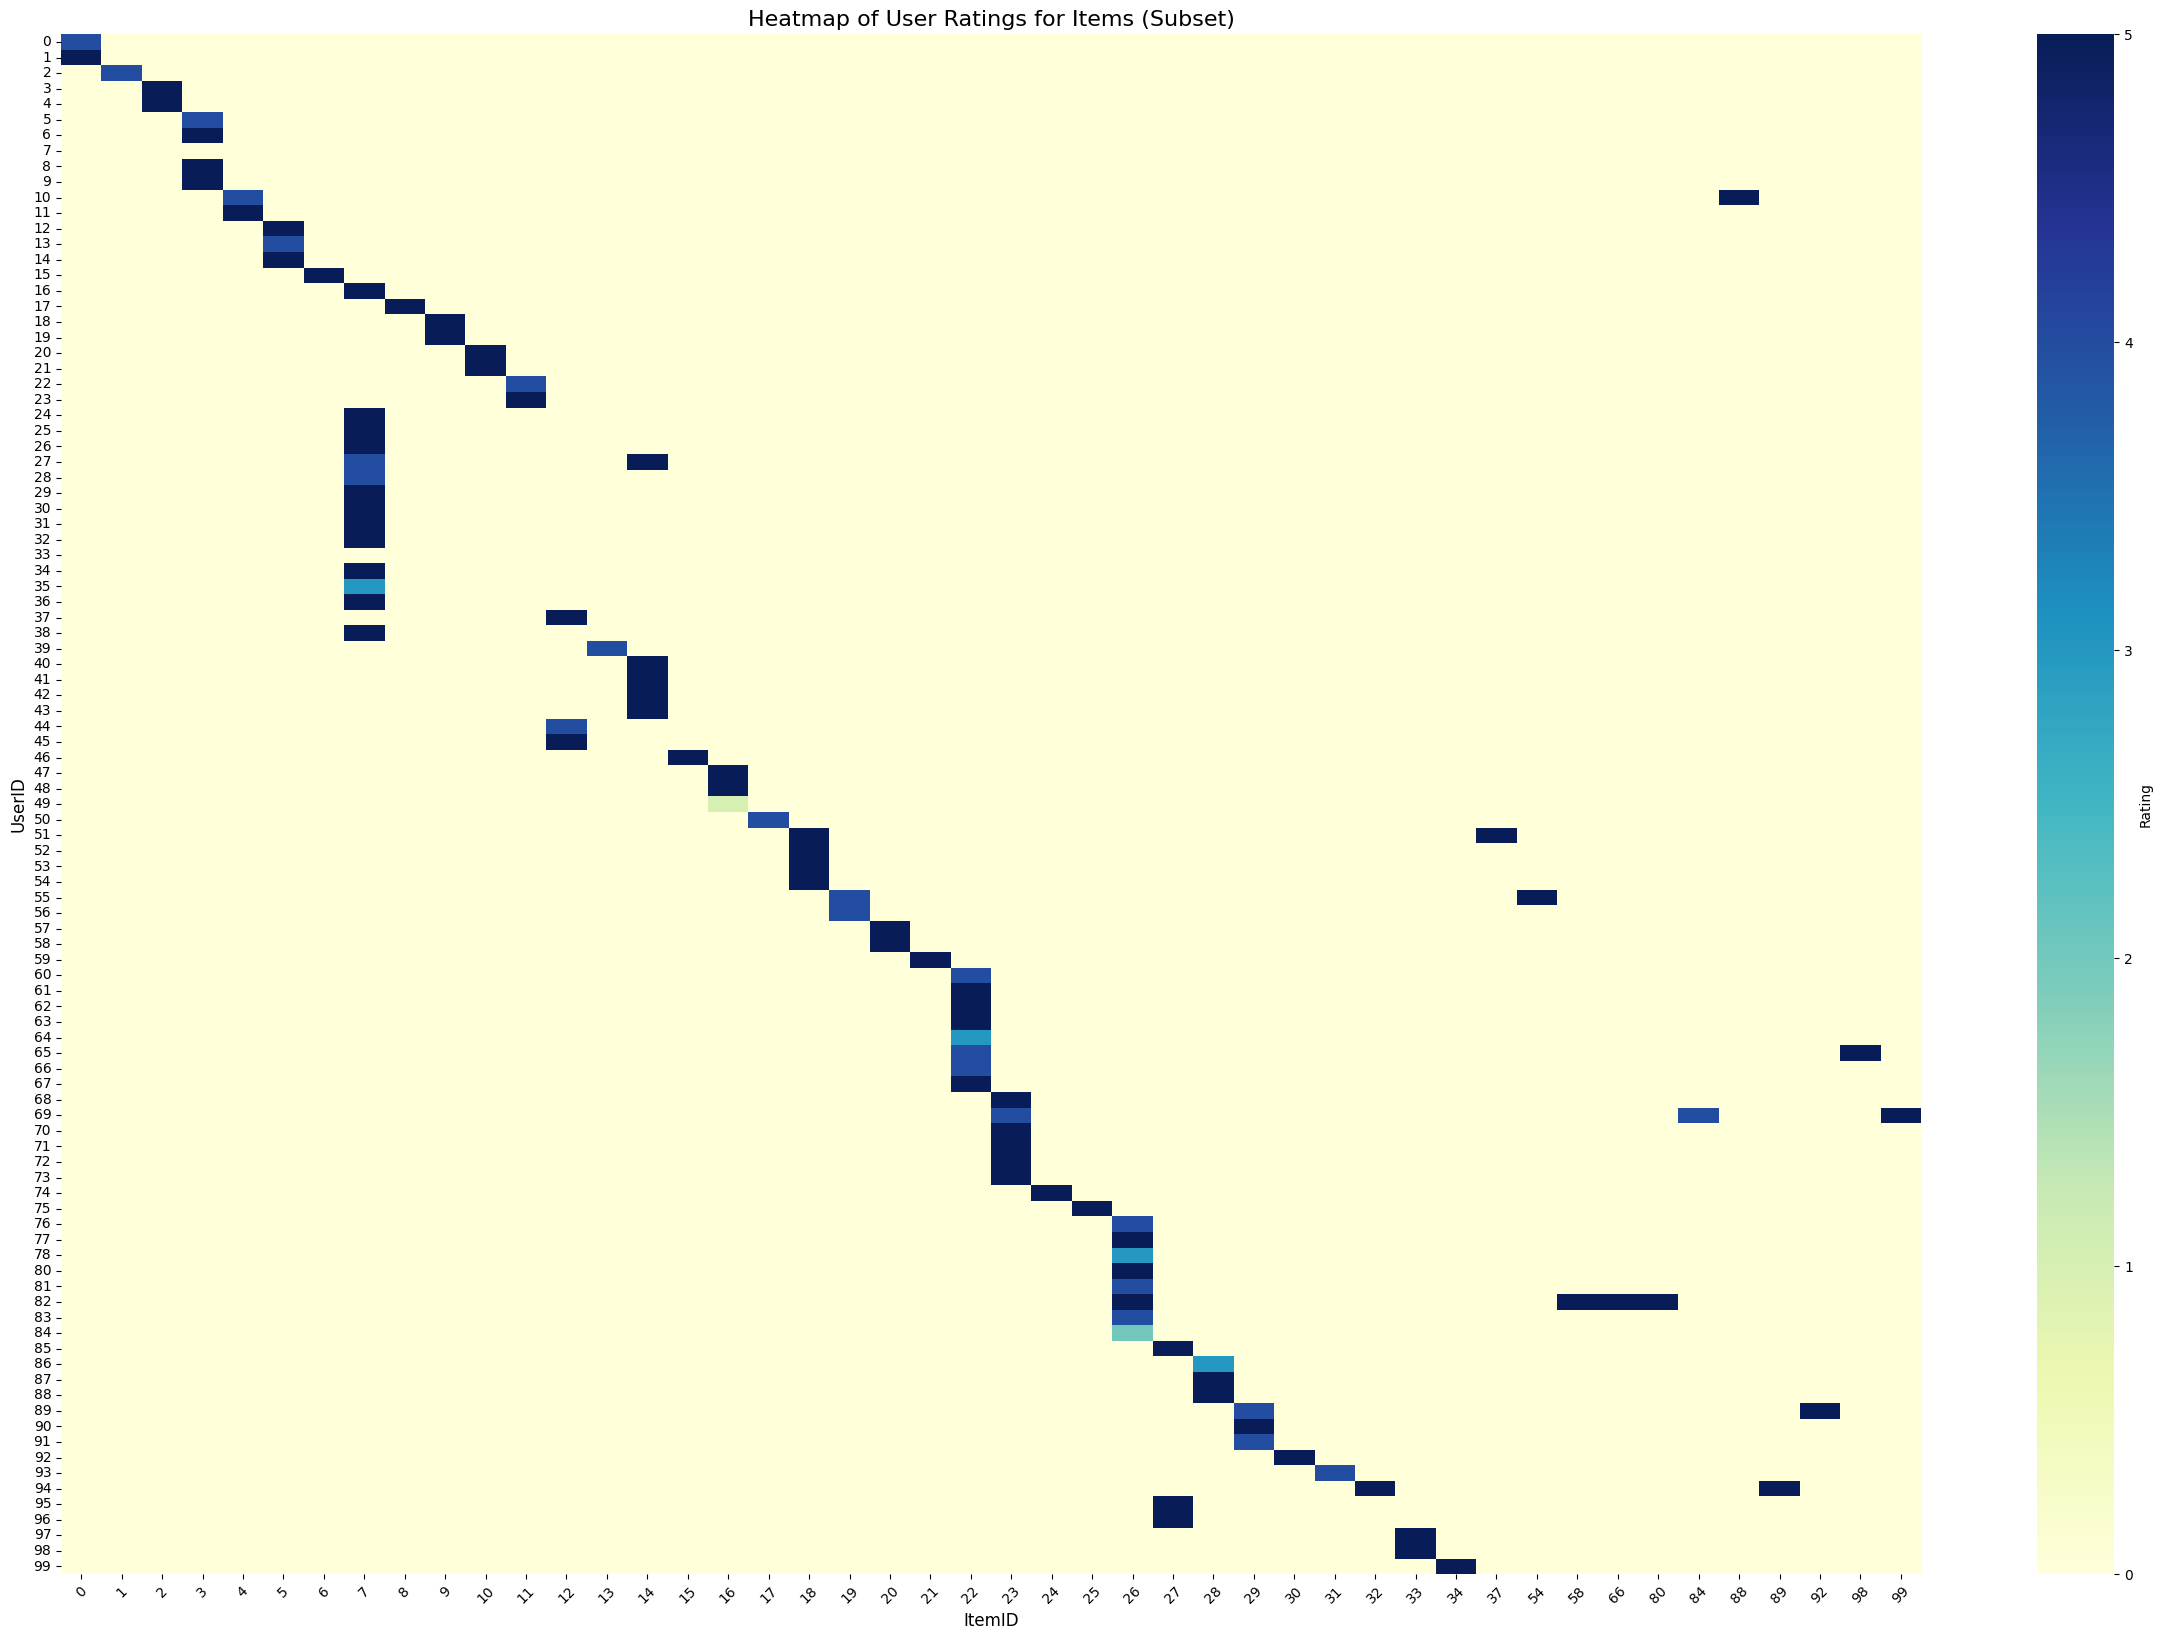

In [ ]:
smaller_ratings_df = ratings_df[ratings_df['userID'].isin(range(100)) & ratings_df['itemID'].isin(range(100))]

# Create the pivot table
smaller_ratings_matrix = smaller_ratings_df.pivot(index='userID', columns='itemID', values='rating').fillna(0)

# Generate the heatmap
plt.figure(figsize=(30, 20))

# Select a subset of data if necessary
smaller_ratings_matrix_subset = smaller_ratings_matrix.iloc[:100, :50]  # Adjust indices as needed
ax = sns.heatmap(smaller_ratings_matrix_subset, cmap='YlGnBu', cbar_kws={'label': 'Rating'})
ax.set_aspect('auto')  # Use 'auto' for automatic aspect or set an aspect ratio

# Adjust font size for better legibility if needed
plt.xticks(fontsize=10, rotation=45)  # Adjust fontsize and rotation as needed
plt.yticks(fontsize=10)

plt.xlabel("ItemID", fontsize=12)
plt.ylabel("UserID", fontsize=12)
plt.title("Heatmap of User Ratings for Items (Subset)", fontsize=16)
plt.show()

User Similarity

In [ ]:
user_ids = ratings_df['userID'].unique()
item_ids = ratings_df['itemID'].unique()

# Create a CSR matrix using the unique identifiers
sparse_user_item_matrix = csr_matrix((ratings_df['rating'], (ratings_df['userID'].astype('category').cat.codes, ratings_df['itemID'].astype('category').cat.codes)))

# Compute cosine similarity
cosine_sim = cosine_similarity(sparse_user_item_matrix, dense_output=False)

# Convert cosine_sim to a DataFrame, using the user IDs as both the index and columns
user_similarity_df = pd.DataFrame(cosine_sim.toarray(), index=user_ids, columns=user_ids)

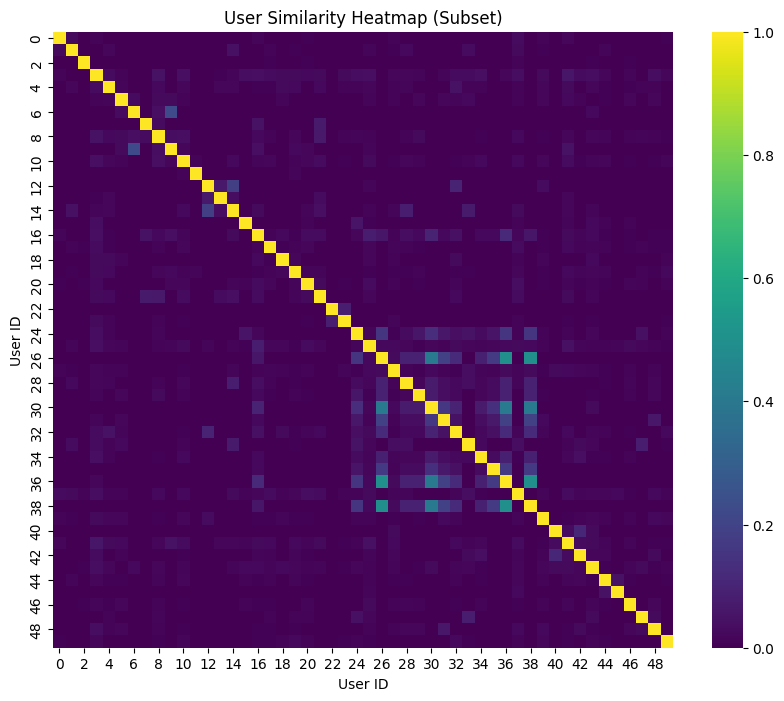

In [ ]:
num_users_to_visualize = 50  # for example, the first 30 users
user_similarity_subset = user_similarity_df.iloc[:num_users_to_visualize, :num_users_to_visualize]

# Create the heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size as needed
sns.heatmap(user_similarity_subset, annot=False, cmap='viridis')
plt.title('User Similarity Heatmap (Subset)')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.show()

In [ ]:
def get_similar_users(user_similarity_df, user_id, top_n=10):
    if user_id not in user_similarity_df.index:
        raise ValueError("User ID not found in user similarity dataframe.")

    user_similarities = user_similarity_df.loc[user_id].sort_values(ascending=False)
    similar_users = user_similarities.drop(user_id, errors='ignore').head(top_n)

    print(f"Top {top_n} similar users to user ID {user_id}:")

    # Here's the correct use of iteritems() on the Series 'similar_users'.
    for similar_user_id, score in similar_users.items():
        print(f"User: {similar_user_id}, Similarity Score: {score}")

    return similar_users.index

def get_recommendations(user_similarity_df, ratings_df, raw_recipes_df, user_id, top_n=10):
    """Get top item recommendations for a given user based on user similarity."""
    # Map itemIDs to recipe names
    recipe_id_name_dict = pd.Series(raw_recipes_df.name.values, index=raw_recipes_df.id).to_dict()
    # Get top similar users
    similar_users = get_similar_users(user_similarity_df, user_id, top_n)
    print("similar users" + str(similar_users))
    # Filter ratings to only include ratings from similar users
    similar_users_ratings = ratings_df[ratings_df['userID'].isin(similar_users)]
    # Calculate mean rating for each item by similar users
    item_ratings = similar_users_ratings.groupby('itemID')['rating'].mean().reset_index()
    # Get the items the user hasn't rated yet
    user_rated_items = ratings_df[ratings_df['userID'] == user_id]['itemID']
    temp = item_ratings[~item_ratings['itemID'].isin(user_rated_items)].sort_values('rating', ascending=False)

    #filter top 10 based on existent ID's and filtering nonexistent ones
    recommendations = pd.DataFrame(columns = temp.columns.tolist())
    for index, row in temp.iterrows():
      if row['itemID'] in recipe_id_name_dict:
        recommendations.loc[len(recommendations.index)] = row
      if len(recommendations) >= 10:
        break

    # Append recipe names to the recommendations
    recommendations['recipeName'] = recommendations['itemID'].apply(lambda x: recipe_id_name_dict.get(x, f"Recipe ID: {x}"))
    return recommendations[['itemID', 'recipeName', 'rating']]

def calculate_carbon_footprint(recipe, ingr_df, carbon_footprint_df):
    total_footprint = 0
    ingredients_list = recipe.ingredients

    # Check if ingredients is a string and convert it to a list if necessary
    if isinstance(ingredients_list, str):
        ingredients_list = ast.literal_eval(ingredients_list)

    for ingredient in ingredients_list:
        # Get the 'replaced' category for the ingredient
        replaced_result = ingr_df.loc[ingr_df['raw_ingr'] == ingredient, 'replaced']

        # Check if the result is not empty
        if not replaced_result.empty:
            macro_category = replaced_result.values[0]

            # Get the total emissions for the 'replaced' category
            emissions_result = carbon_footprint_df.loc[carbon_footprint_df['Food product'] == macro_category, 'Total_emissions']

            # Check if the result is not empty and add to total footprint
            if not emissions_result.empty:
                total_footprint += emissions_result.values[0]
        else:
            # Handle the case where the ingredient is not found
            print(f"Ingredient '{ingredient}' not found in ingredient mapping.")

    return total_footprint

user_id_to_check = 26
# print("Recommendations for user "+ str(user_id_to_check))
recommendations = get_recommendations(user_similarity_df, ratings_df, raw_recipes_df, user_id_to_check, top_n=10)
# print(recommendations)

#converts the recipe IDs in order given
recipeIDList = recommendations['itemID'].tolist()
filtered_recipes_df = raw_recipes_df[raw_recipes_df['id'].isin(recipeIDList)]


filtered_recipes_df['Carbon Footprint'] = filtered_recipes_df.apply(lambda row: calculate_carbon_footprint(row, ingr_df, carbon_footprint_df), axis=1)
# print(filtered_recipes_df.columns.tolist())

print(filtered_recipes_df.loc[:,['name', 'Carbon Footprint']].head(10))

# Sort filtered_recipes_df by "Carbon Footprint"

filtered_recipes_df_sorted = filtered_recipes_df.sort_values(by="Carbon Footprint")
# print(filtered_recipes_df_sorted.columns.tolist())

print(filtered_recipes_df_sorted.loc[:,['name', 'Carbon Footprint']].head(10))

# Get the order of IDs after sorting
sorted_ids = filtered_recipes_df_sorted["id"].tolist()

# Reorder recommendations DataFrame based on the sorted IDs
recommendations = recommendations.set_index("itemID").loc[sorted_ids].reset_index()
print(recommendations)

Top 10 similar users to user ID 26:
User: 38, Similarity Score: 0.4999999999999999
User: 23189, Similarity Score: 0.4999999999999999
User: 36, Similarity Score: 0.4999999999999999
User: 14401, Similarity Score: 0.4602873089491617
User: 22582, Similarity Score: 0.40824829046386296
User: 30, Similarity Score: 0.40824829046386296
User: 11032, Similarity Score: 0.40824829046386296
User: 13678, Similarity Score: 0.35714285714285715
User: 19974, Similarity Score: 0.3162277660168379
User: 21075, Similarity Score: 0.3162277660168379
similar usersIndex([38, 23189, 36, 14401, 22582, 30, 11032, 13678, 19974, 21075], dtype='int64')
Ingredient 'dried carrots' not found in ingredient mapping.
                                                 name  Carbon Footprint
8945    artichokes chilled with champagne vinaigrette              16.2
32022                       buttered spaghetti squash               2.8
82622                  fat free sour cream pound cake              17.4
105274                  

<ipython-input-23-c229c793569d>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_recipes_df['Carbon Footprint'] = filtered_recipes_df.apply(lambda row: calculate_carbon_footprint(row, ingr_df, carbon_footprint_df), axis=1)
